In [1]:
import os
import sys
import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
import torch
import nibabel as nib
from nilearn.plotting import *
from nilearn import image
import torchio
from torchio import AFFINE, DATA, PATH, TYPE, STEM
import seaborn as sns

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits



In [6]:
import imp

import data_processor
imp.reload(data_processor)
import utils.visualization_tools as visualization_tools
imp.reload(visualization_tools)
from utils.visualization_tools import *
import utils.routine as routine
imp.reload(routine)
from utils.routine import *

In [3]:
fcd_pirogov_seg_data = data_processor.DataMriSegmentation(sample='pirogov', prefix='fcd', mask='seg', ignore_missing=True,
                         coord_min=(30,30,30, ), img_shape=(192, 192, 192, ),
                         image_path= '../../datasets/fcd_classification_bank',
                         targets_path= 'targets/targets_fcd_bank.csv')

print('\n')
print(f'Dataset size: {len(fcd_pirogov_seg_data)}')
print(f'Labels distribution: {np.unique(fcd_pirogov_seg_data.target, return_counts=True)}\n')

#Example of data 
img, seg = fcd_pirogov_seg_data[1]
print("Image shape: {}".format(img.shape))
print("Segmentation shape: {}".format(seg.shape))

  7%|▋         | 1/15 [00:00<00:01,  9.79it/s]

Assembling data for: pirogov sample.


100%|██████████| 15/15 [00:01<00:00, 12.05it/s]




Dataset size: 15
Labels distribution: (array([1]), array([15]))

Image shape: torch.Size([1, 192, 192, 192])
Segmentation shape: torch.Size([1, 192, 192, 192])


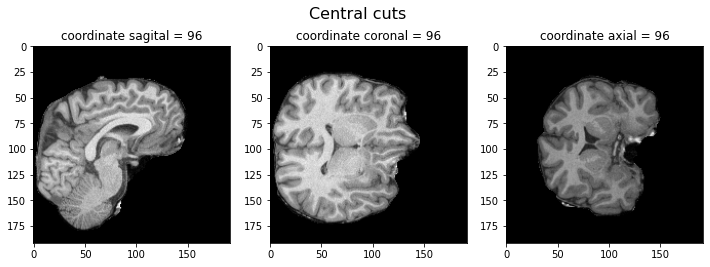

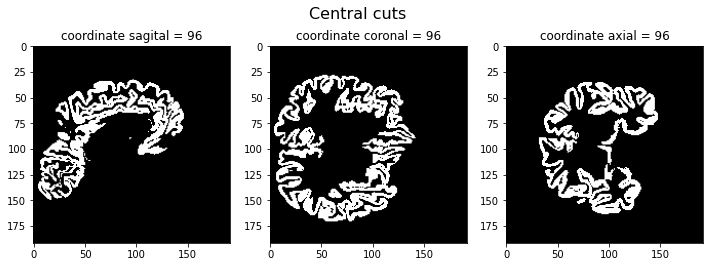

In [4]:
plot_central_cuts(img)
plot_central_cuts(seg)

### Preprocessing data

In [7]:
histogram_landmarks_path = 'landmarks/fcd_train_data_landmarks.npy'
# for recreating landmarks remove # below 
# image_paths = list(fcd_data.img_files[train_idx].values)
# landmarks = HistogramStandardization.train(image_paths, output_path=histogram_landmarks_path)
landmarks = np.load(histogram_landmarks_path)

training_transform = Compose([
    HistogramStandardization(landmarks={'MRI': landmarks}),
    RandomBiasField(),
    ZNormalization(masking_method=ZNormalization.mean),
    CropOrPad((200, 200, 200)),
    RandomFlip(axes=(0,)),
    OneOf({
        RandomAffine(): 0.8,
        RandomElasticDeformation(): 0.2,
    }),
])

validation_transform = Compose([
    HistogramStandardization(landmarks={'MRI': landmarks}),
    ZNormalization(masking_method=ZNormalization.mean),
    CropOrPad((200, 200, 200)),
])

### Getting torchio preprocessed dataset from data 

In [8]:
dataset = get_torchio_dataset(fcd_pirogov_seg_data.img_files, fcd_pirogov_seg_data.img_seg, training_transform)

In [9]:
dataset.subjects

[Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2),
 Subject(Keys: ('MRI', 'LABEL'); images: 2)]

### Splitting data into train and test parts 

In [11]:
from sklearn.model_selection import StratifiedKFold, ShuffleSplit
cv = ShuffleSplit(n_splits = 1,  test_size = 0.3, random_state = 42)
cv_splits = list(cv.split(X=np.arange(len(fcd_pirogov_seg_data)), y=fcd_pirogov_seg_data.target))

### Creating dataloaders for model 

In [12]:
training_loader, validation_loader = get_loaders(fcd_pirogov_seg_data, cv_splits[0],
        training_transform = training_transform,
        validation_transform = validation_transform)

Training set: 10 subjects
Validation set: 5 subjects


In [14]:
random_batch = next(iter(training_loader))

In [21]:
random_batch['MRI'][DATA]

tensor([[[[[-2.0259, -2.0259, -2.0259,  ..., -2.0259, -2.0259, -2.0259],
           [-2.0259, -2.0259, -2.0259,  ..., -2.0259, -2.0259, -2.0259],
           [-2.0259, -2.0259, -2.0259,  ..., -2.0259, -2.0259, -2.0259],
           ...,
           [-2.0259, -2.0259, -2.0259,  ..., -2.0259, -2.0259, -2.0259],
           [-2.0259, -2.0259, -2.0259,  ..., -2.0259, -2.0259, -2.0259],
           [-2.0259, -2.0259, -2.0259,  ..., -2.0259, -2.0259, -2.0259]],

          [[-2.0259, -2.0259, -2.0259,  ..., -2.0259, -2.0259, -2.0259],
           [-2.0259, -2.0259, -2.0259,  ..., -2.0259, -2.0259, -2.0259],
           [-2.0259, -2.0259, -2.0259,  ..., -2.0259, -2.0259, -2.0259],
           ...,
           [-2.0259, -2.0259, -2.0259,  ..., -2.0259, -2.0259, -2.0259],
           [-2.0259, -2.0259, -2.0259,  ..., -2.0259, -2.0259, -2.0259],
           [-2.0259, -2.0259, -2.0259,  ..., -2.0259, -2.0259, -2.0259]],

          [[-2.0259, -2.0259, -2.0259,  ..., -2.0259, -2.0259, -2.0259],
           [-2.

In [16]:
random_batch['LABEL'][DATA]

tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          ...,

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           

### Getting model and optimizer 

In [25]:
from unet import UNet

In [26]:
UNet()

UNet(
  (encoder): Encoder(
    (encoding_blocks): ModuleList(
      (0): EncodingBlock(
        (conv1): ConvolutionalBlock(
          (conv_layer): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
          (activation_layer): ReLU()
          (block): Sequential(
            (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
            (1): ReLU()
          )
        )
        (conv2): ConvolutionalBlock(
          (conv_layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (activation_layer): ReLU()
          (block): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
            (1): ReLU()
          )
        )
        (downsample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): EncodingBlock(
        (conv1): ConvolutionalBlock(
          (conv_layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
          (activation_layer): ReLU()
          (block): Sequential(
            (0): C

In [ ]:
def get_model_and_optimizer(device, num_encoding_blocks = 3, out_channels_first_layer = 16, patience = 3):
    
    '''
    Function creates model, optimizer and scheduler
    
    Arguments:
     *
    
    Output:
     * 
    '''
    
    # reproducibility
    # https://pytorch.org/docs/stable/notes/randomness.html
    torch.manual_seed(0)
    np.random.seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    model = UNet(
        in_channels = 1,
        out_classes = 2,
        dimensions = 3,
        num_encoding_blocks = num_encoding_blocks,
        out_channels_first_layer = out_channels_first_layer,
        normalization = 'batch',
        upsampling_type = 'linear',
        padding = True,
        activation = 'PReLU',
    ).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters())
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, threshold=0.01)
    
    return model, optimizer, scheduler

In [ ]:
def forward(model, inputs):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        logits = model(inputs)
    return logits

In [ ]:
class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'
    
def run_epoch(epoch_idx, action, loader, model, optimizer, scheduler = False, experiment = False):
    is_training = action == Action.TRAIN
    epoch_losses = []
    model.train(is_training)
    
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(is_training):
            logits = forward(model, inputs)
            probabilities = F.softmax(logits, dim = CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets)
            batch_loss = batch_losses.mean()
            
            if is_training:
                batch_loss.backward()
                optimizer.step()
                
            # appending the loss
            epoch_losses.append(batch_loss.item())
           
            if experiment:
                if action == Action.TRAIN:
                    experiment.log_metric("train_dice_loss", batch_loss.item())
                elif action == Action.VALIDATE:
                    experiment.log_metric("validate_dice_loss", batch_loss.item())
                    
            del inputs, targets, logits, probabilities, batch_losses
    
    epoch_losses = np.array(epoch_losses)
#     print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')
    
    return epoch_losses 